In [123]:
import pandas as pd
# On charge le fichier csv qui se trouve dans un sous-dossier 'data'
data = pd.read_csv("./data/GlobalTemperatures.csv")
# On charge les températures moyennes (terre et océan confondus) dans une série de données Pandas,
# à partir de la 1300ème ligne (il n'y a aucune donnée avant cela).
# On réalise aussi une interpolation pour remplir automatiquement certaines valeurs manquantes
temperature = data["LandAndOceanAverageTemperature"].interpolate(limit_direction="backward")[1300:]
dates = pd.to_datetime(data["dt"])[1300:]

In [124]:
from statsmodels.tsa.stattools import adfuller

def make_stationary(time_series):
    """
    Makes a time series stationary while the p-value computed using the ADF test is higher than 0.05
    """
    test_results = adfuller(time_series)
    p_value = test_results[1]
    if p_value > 0.05: # i.e. if the data is not stationary
        # Differentiating until the p-value goes under 0.05
        diff_data = time_series.copy()
        for degree in range(1, 10):
            diff_data = diff_data.diff().dropna()
            if adfuller(diff_data)[1] <= 0.05:
                return diff_data, degree
        
        raise ValueError(f"Unable to stationarize data after diferentiating {degree} times")
    return time_series

_, diff_degree = make_stationary(temperature)
print(f"Degrees of differentiating: {diff_degree}")

Degrees of differentiating: 1


In [125]:
from pmdarima.model_selection import train_test_split

# On commence par séparer nos jeux d'entraînement et de test
training_samples_count = int(len(dates) * 0.9)
train, test = train_test_split(temperature, train_size=training_samples_count)
train_dates, future_dates = train_test_split(dates, train_size=training_samples_count)

In [126]:
# Recherche des meilleurs paramètres pour notre ARIMA
# Comme nous avons déjà déterminé que notre degré de différenciation
# est de 1, nous pouvons le préciser à auto_arima pour gagner du temps
# d'exécution
from pmdarima import auto_arima
# On choisit une valeur de 12 pour la saisonnalité car nos données
# sont des moyennes mensuelles
best_model = auto_arima(train, d=1, seasonal=True, m=12, stepwise=False, n_jobs=-1, trace=True)
print(best_model)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3381.541, Time=0.23 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1856.148, Time=1.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2098.778, Time=0.41 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=953.767, Time=4.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1266.363, Time=2.44 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1275.399, Time=2.76 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=674.782, Time=7.75 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=-1964.354, Time=14.11 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-2051.517, Time=8.03 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=15.82 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1368.627, Time=0.65 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=817.045, Time=2.06 sec
 ARIMA(0,1,1)

In [130]:
from pmdarima.arima import ARIMA

# On instancie notre modèle avec les hyperparamètres définis plus tôt
model = ARIMA(
    order=(1, 1, 1),
    seasonal_order=(2, 0, 1, 12)
               )
model.fit(train)

predictions_count = len(test)
# On réalise des prédictions à comparer avec les valeurs de test
forecast, confidence_intervals = model.predict(predictions_count, return_conf_int=True) 


/home/vincent/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vincent/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vincent/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[[14.5585685  15.03418914]
 [15.36794548 15.93707052]
 [16.09447743 16.70055743]
 [16.73201684 17.35448075]
 [16.99998231 17.63033045]
 [16.90447933 17.53895428]
 [16.29357588 16.93042282]
 [15.43271931 16.07107366]
 [14.43348211 15.07289472]
 [13.86475392 14.50497962]
 [13.63890798 14.27980705]
 [14.03005792 14.67154796]
 [14.5303572  15.18359236]
 [15.36441634 16.02372974]
 [16.09528179 16.75805228]
 [16.7311515  17.39609694]
 [16.99736702 17.66382528]
 [16.90128806 17.56889946]
 [16.2904039  16.95896425]
 [15.43246524 16.10185441]
 [14.43617178 15.10631711]
 [13.86876181 14.53961846]
 [13.64467781 14.31621762]
 [14.03324487 14.70544996]
 [14.53174937 15.21504049]
 [15.36268003 16.05194703]
 [16.09076858 16.78359267]
 [16.72420983 17.41937914]
 [16.98931627 17.68619012]
 [16.89341695 17.59163985]
 [16.2845149  16.98388145]
 [15.42945053 16.12983816]
 [14.43651589 15.13784965]
 [13.87096591 14.57319909]
 [13.6475586  14.35066167]
 [14.03463844 14.73859245]
 [14.53122011 15.24652788]
 

In [140]:
# Adding confidence intervals
ci_dict = {
    "low": confidence_intervals[:, 0],
    "high": confidence_intervals[:, 1]
}
confidence_intervals_df = pd.DataFrame(ci_dict)
confidence_intervals_df.index = future_dates

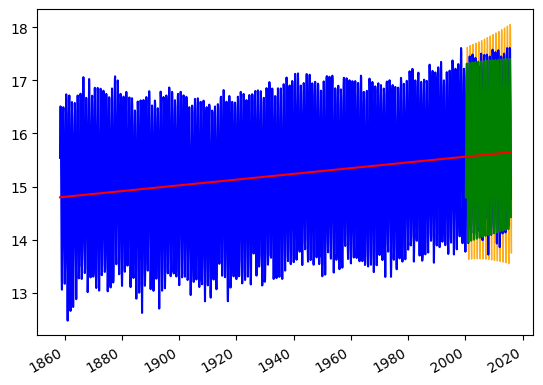

In [141]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(train_dates) + len(future_dates))
trend = np.polyfit(x, pd.concat([train, forecast]), 1)


trendpoly = np.poly1d(trend)
plt.plot(dates, temperature, c='blue')
plt.plot(future_dates, forecast, c='green')
plt.plot(dates, trendpoly(x), c="red")
plt.fill_between(confidence_intervals_df.index, confidence_intervals_df['low'], confidence_intervals_df['high'], alpha=0.9, color='orange', label="Confidence intervals")
plt.gcf().autofmt_xdate()
plt.show()

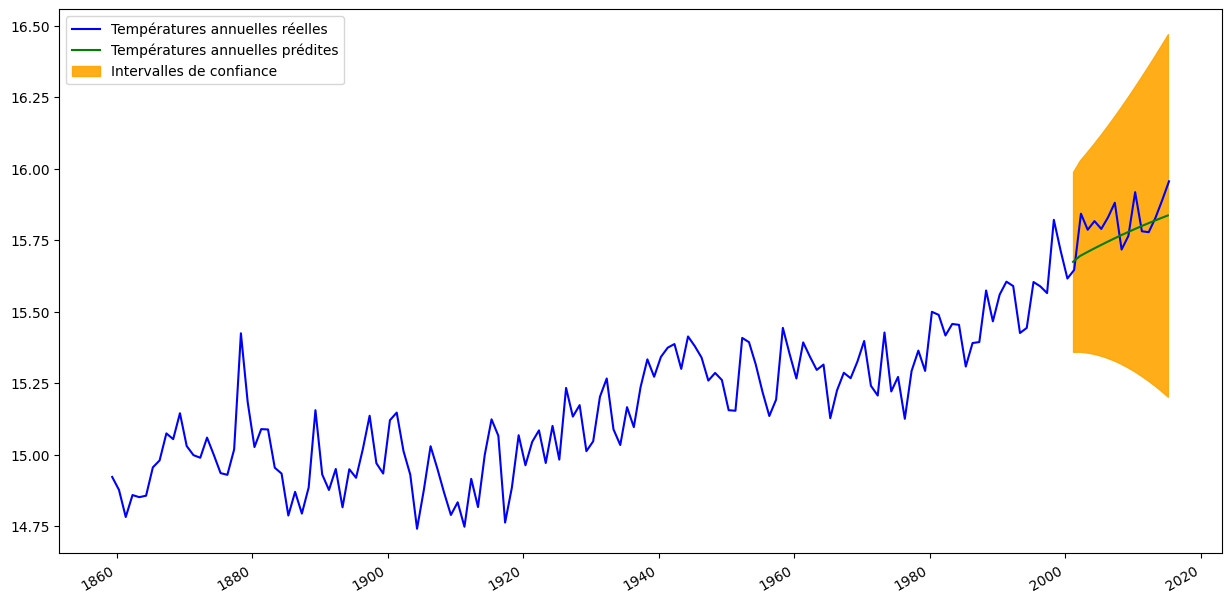

In [145]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))



# Computing yearly average in order to increase readibility
temperature.index = dates
yearly_temperature = temperature.rolling(window=12, step=12, center=False).mean().dropna()

train.index = train_dates
yearly_train = train.rolling(window=12, step=12, center=False).mean().dropna()

forecast.index = future_dates
yearly_forecast = forecast.rolling(window=12, step=12, center=False).mean().dropna()

train_and_forecast = pd.concat([yearly_train, yearly_forecast])
x = np.arange(len(train_and_forecast))
trend = np.polyfit(x, train_and_forecast, 1)
trendpoly = np.poly1d(trend)

yearly_train_dates = pd.Series(yearly_train.index)
yearly_forecast_dates = pd.Series(yearly_forecast.index)
all_dates = pd.concat([yearly_train_dates, yearly_forecast_dates])

yearly_confidence_intervals_df = confidence_intervals_df.rolling(window=12, step=12, center=False).mean().dropna()

plt.plot(yearly_temperature, c='blue', label='Températures annuelles réelles')
plt.plot(yearly_forecast_dates, yearly_forecast.values, c='green', label='Températures annuelles prédites')
#plt.plot(train_and_forecast.index, trendpoly(x), c="red", label='Forecast trend')
plt.fill_between(yearly_confidence_intervals_df.index, yearly_confidence_intervals_df['low'], yearly_confidence_intervals_df['high'], alpha=0.9, color='orange', label="Intervalles de confiance")
plt.legend(loc='upper left')
plt.gcf().autofmt_xdate()


In [146]:
# Calcul de la RMSE
import math
from sklearn.metrics import mean_squared_error

def rmse(true_values, predicted_values):
    """
    Computes the Root Mean-Squared Error of the predicted values with regards to the actual values.
    """
    return math.sqrt(mean_squared_error(true_values, predicted_values))

# Exemple avec nos prédictions :
print(f"RMSE : {rmse(test, forecast)}")


RMSE : 0.1547609757706522


## Importations

In [145]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import SGDRegressor
import numpy as np
import matplotlib.pyplot as plt

SPLIT_DATASET = True # Use this if you want to perform tests on parts of the time series
DATASET_SPLIT_RATIO = 0.85 # If SPLIT_DATASET, is set to True, defines how much of the data should be used for training
FORECAST_LENGTH = 120 # Number of forecast samples to generate if SPLIT_DATASET is set to False


In [146]:
def make_stationary(time_series):
    """
    Make a time series stationary if the p-value computed using the ADF test is higher than 0.05
    """
    test_results = adfuller(time_series)
    p_value = test_results[1]
    if p_value > 0.05: # i.e. if the data is not stationary
        # Differentiating until the p-value goes under 0.05
        diff_data = time_series.copy()
        for degree in range(1, 10):
            diff_data = diff_data.diff().dropna()
            if adfuller(diff_data)[1] <= 0.05:
                return diff_data, degree
        
        raise ValueError(f"Unable to stationarize data after diferentiating {degree} times")
    return time_series



def decompose_data(time_series):
    """
    Decompose our data following an additive model
    """
    additive_decomposition = seasonal_decompose(time_series.values, model='additive', period=12)
    return {
        "trend": additive_decomposition.trend,
        "seasonal": additive_decomposition.seasonal,
        "residual": additive_decomposition.resid
    }
        

## Chargement des données

In [160]:
data = pd.read_csv("./data/GlobalTemperatures.csv")
print(data.head())
# Getting rid of empty values (the first 1300 or so are missing)
temp = data["LandAndOceanAverageTemperature"].interpolate(limit_direction="backward")[1300:]
dates = pd.to_datetime(data["dt"])[1300:]

if SPLIT_DATASET:
    TRAINING_SAMPLES_COUNT = int(len(dates) * DATASET_SPLIT_RATIO)
    train, test = train_test_split(temp, train_size=TRAINING_SAMPLES_COUNT)
    train_dates, future_dates = train_test_split(dates, train_size=TRAINING_SAMPLES_COUNT)


else:
    train = temp
    train_dates = dates

# Making our series stationary
train_components = decompose_data(train)
detrended_train = train.values - train_components["trend"]
trend_train = pd.Series(train_components["trend"])
detrended_train = pd.Series(detrended_train).reset_index(drop=True)



AttributeError: 'DataFrame' object has no attribute 'summary'

## Recherche des meilleurs paramètres et entraînement

Paramètres du meilleur modèle :
Best model:  ARIMA(1,1,1)(2,0,2)[12] intercept

In [156]:
trend_train = trend_train.dropna()
print(np.array(trend_train.index).reshape(-1, 1))
print(np.array(trend_train.values))

#model = auto_arima(train, seasonal=True, m=12, trace=True)
#print(str(model.summary()))
model = ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 12))
model.fit(detrended_train)

# ENTRAÎNER UN MODÈLE DE RÉGRESSION SUR LA TENDANCE ICI :
trend_model = SGDRegressor()
trend_model.fit(np.array(trend_train.index).reshape(-1, 1), trend_train.interpolate().values)


[[   6]
 [   7]
 [   8]
 ...
 [1599]
 [1600]
 [1601]]
[14.90904167 14.93216667 14.941      ... 15.60566667 15.60825
 15.60308333]


SGDRegressor()

## Prédiction

In [158]:
if SPLIT_DATASET:
    detrended_forecasts = model.predict(len(test))  # predict N steps into the future
    future_index = np.arange(trend_train.index[-1]+1, trend_train.index[-1]+1 + len(test)).reshape(-1, 1)
    trend_forecasts = trend_model.predict(future_index)

    forecasts = detrended_forecasts + trend_forecasts
    print(forecasts)
else:
    forecasts = model.predict(FORECAST_LENGTH)  # predict 10 years into the future

forecasts = pd.Series(forecasts)

1608    8.385640e+13
1609    8.390871e+13
1610    8.396102e+13
1611    8.401333e+13
1612    8.406564e+13
            ...     
1887    9.845088e+13
1888    9.850319e+13
1889    9.855550e+13
1890    9.860781e+13
1891    9.866012e+13
Length: 284, dtype: float64


## Visualisation

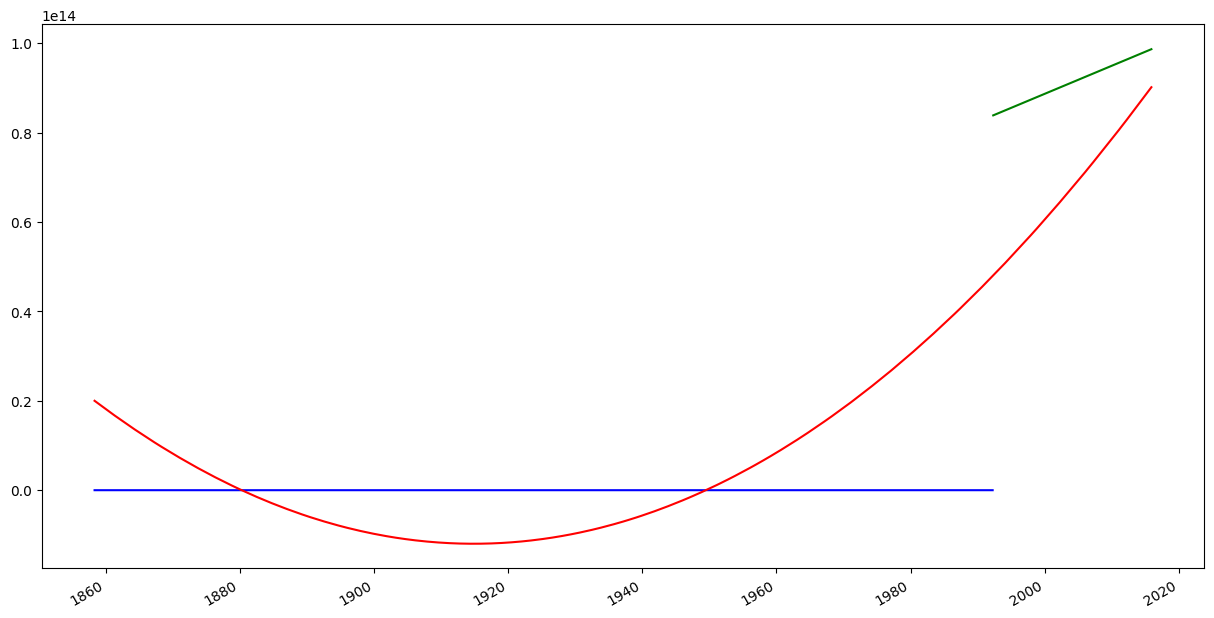

In [159]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(15,8))


if SPLIT_DATASET:
    x = np.arange(len(train) + len(forecasts))
    trend = np.polyfit(x, pd.concat([train, forecasts]), 2)

else:
    # Generating extra dates for the forecast
    start_date = dates.iloc[-1] + pd.DateOffset(months=1)
    future_dates = pd.date_range(start_date, periods=FORECAST_LENGTH, freq="M").to_series()
    all_dates = pd.concat([dates, future_dates])
    x = np.arange(len(train) + len(forecasts))
    trend = np.polyfit(x, pd.concat([train, forecasts]), 2)




trendpoly = np.poly1d(trend)
plt.plot(train_dates, train, c='blue')
plt.plot(future_dates, forecasts, c='green')
plt.plot(all_dates, trendpoly(x), c="red")
plt.gcf().autofmt_xdate()
plt.show()

1892
1608
284
1892
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1887    0.007205
1888    0.691547
1889    1.231055
1890    1.473897
1891    1.416328
Name: 0, Length: 1892, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1887   NaN
1888   NaN
1889   NaN
1890   NaN
1891   NaN
Length: 1892, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
95    14.713
96    15.630
97    16.596
98    17.060
99    16.695
Length: 100, dtype: float64
(3192, 2)


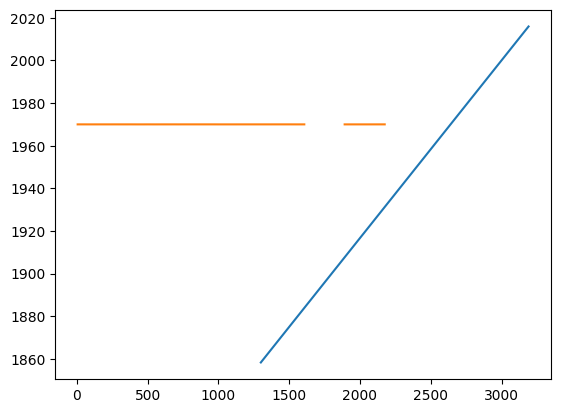

In [135]:
# Reintegrating trends + comparing forecasts to actual values

if SPLIT_DATASET:

    trend_data = pd.Series(components["trend"])
    all_temp = pd.concat([train, forecasts]).reset_index().drop(columns="index")[0]

    full_data = all_temp + trend_data


detrended_data = {
    "date": all_dates,
    "detrended_temp": pd.concat([train, forecasts])
}

detrended_df = pd.DataFrame(detrended_data)
print(detrended_df.shape)
plt.plot(detrended_df)


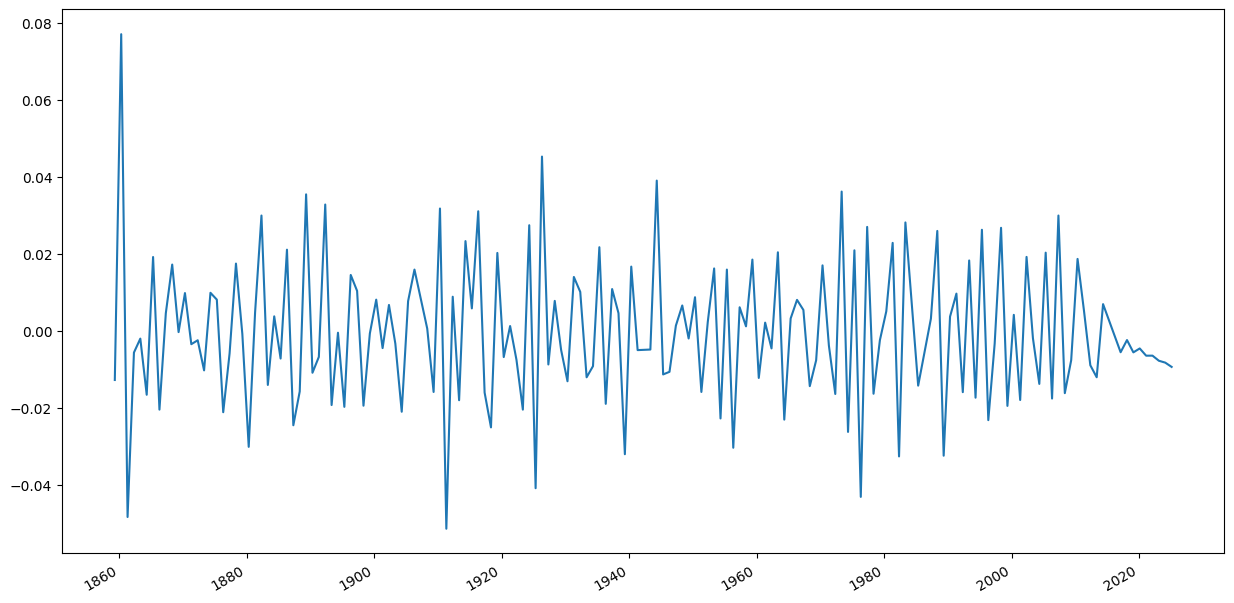

In [88]:
# Visualisation en faisant des moyennes de température annuelles, pour plus de visibilité
plt.figure(figsize=(15,8))

train.index = train_dates
yearly_train = train.rolling(window=12, step=12, center=True).mean().dropna()

forecasts.index = future_dates
yearly_forecasts = forecasts.rolling(window=12, step=12, center=True).mean().dropna()

all_data = pd.concat([yearly_train, yearly_forecasts])
x = np.arange(len(all_data))

plt.plot(all_data)
plt.gcf().autofmt_xdate()

